# Data Modelling

In [2]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import RandomOverSampler



In [3]:
# importing all cleaned text

comments = pd.read_pickle("data/comments_final.pkl")

#### Lemmatizing

In [4]:
def get_lems(text):
    lemmatizer = WordNetLemmatizer()
    lem_tokens = [lemmatizer.lemmatize(text) for text in text]
    return lem_tokens

In [5]:
comments['lemmatize'] = comments['tokenize'].apply(get_lems)

In [6]:
# join lemmatized words

def join_lems(text):
    return ' '.join(text)

In [7]:
comments['lemmatize'] = comments['lemmatize'].apply(join_lems)

In [8]:
comments.head()

,video_id,comment,comment_date,binary,tokenize,bigrams,trigrams,lemmatize
0,xJlgtV8L7Jc,For more on this: https://sc.mp/gjys,2023-07-26 04:11:40+00:00,1,[url],[],[],url
1,xJlgtV8L7Jc,"Yes, punish the criminals , not the innocent ...",2023-08-03 03:52:04+00:00,0,"[yes, punish, innocent, people]","[(yes, punish), (punish, innocent), (innocent,...","[(yes, punish, innocent), (punish, innocent, p...",yes punish innocent people
2,xJlgtV8L7Jc,Flor Contemplacion had been there. Filipinos k...,2023-08-02 15:10:36+00:00,1,"[flor, contemplacion, made, experience]","[(flor, contemplacion), (contemplacion, made),...","[(flor, contemplacion, made), (contemplacion, ...",flor contemplacion made experience
3,xJlgtV8L7Jc,Don't mind these westoids. I'm half Indonesian...,2023-08-01 08:46:42+00:00,1,"[dont, mind, westoids, half, indonesianmalaysi...","[(dont, mind), (mind, westoids), (westoids, ha...","[(dont, mind, westoids), (mind, westoids, half...",dont mind westoids half indonesianmalaysian ap...
4,xJlgtV8L7Jc,No wonder Singapore has the most powerful pass...,2023-08-01 07:57:54+00:00,1,"[wonder, powerful, passport, toppling, japan, ...","[(wonder, powerful), (powerful, passport), (pa...","[(wonder, powerful, passport), (powerful, pass...",wonder powerful passport toppling japan year d...


### Train-Test-Split

In [9]:
X = comments['lemmatize']
y = comments['binary']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Logistic Regression with TF-IDF

Logistic Regression is a simple classification model which requires low computational power. We use this model to first set a baseline.

TF-IDF will be used over CountVectorizer for all models as it can give higher weight to words with stronger semantic meaning and importance in the corpus. Whereas CountVectorizer would just assign all words similar weights.

In [11]:
# instatiate logreg and tfidf

pipe_logreg = ImblearnPipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())])

In [12]:
pipe_logreg_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'logreg__class_weight': ['balanced'],
    'logreg__solver' : ['liblinear'],
    'logreg__C': [0.5,1,3,5,10]
}

In [13]:
gs1 = GridSearchCV(pipe_logreg,
                   param_grid = pipe_logreg_params,
                   cv=5,
                   scoring = 'f1')

In [14]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.5, 1, 3, 5, 10],
                         'logreg__class_weight': ['balanced'],
                         'logreg__solver': ['liblinear'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1')

#### Scores and confusion matrix

In [15]:
# scores function

def get_scores(gs, X, y):
    pred = gs.predict(X)
    print(f'Accuracy score: {round(accuracy_score(y, pred), 4)}')
    print(f'Precision score: {round(precision_score(y, pred), 4)}')
    print(f'Specificity score: {round(recall_score(y, pred), 4)}')
    print(f'F1 score: {round(f1_score(y, pred), 4)}')

In [16]:
# train data

get_scores(gs1, X_train, y_train)

Accuracy score: 0.8481
Precision score: 0.9227
Specificity score: 0.8626
F1 score: 0.8916


In [17]:
# test data

get_scores(gs1, X_test, y_test)

Accuracy score: 0.7683
Precision score: 0.86
Specificity score: 0.8125
F1 score: 0.8356


In [18]:
# best hyperparams

print(gs1.best_estimator_)

Pipeline(steps=[('tvec', TfidfVectorizer(max_features=5000)),
                ('logreg',
                 LogisticRegression(C=1, class_weight='balanced',
                                    solver='liblinear'))])


In [19]:
# function for confusion matrix

def get_cm(gs):
    pred = gs.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive'])
    cm_plot.plot()

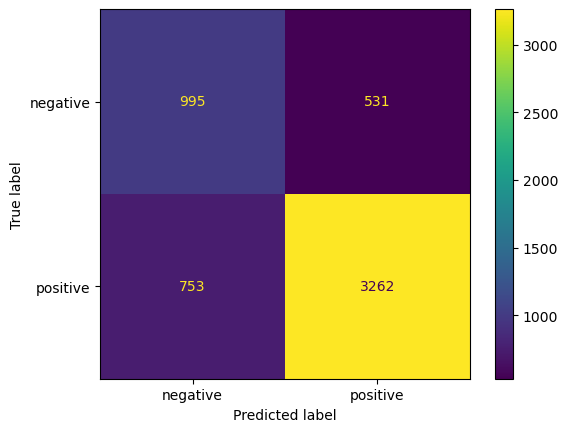

In [20]:
# confusion matrix

get_cm(gs1)

### Logistic Regression with TF-IDF and SMOTE

Since there is an imbalance in our data set, we use SMOTE to address and counter this in the modelling. SMOTE generates synthetic samples for the minority class, and creates a more balanced distribution of classes in our training data. 

This will be used for the subsequent models as well. 

In [21]:
pipe_lr_smt = ImblearnPipeline([
    ('tvec', TfidfVectorizer()),
    ('smote', SMOTE()),
    ('logreg', LogisticRegression())])

In [22]:
gs2 = GridSearchCV(pipe_lr_smt,
                   param_grid = pipe_logreg_params,
                   cv=5,
                   scoring = 'f1')

In [23]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('smote', SMOTE()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [0.5, 1, 3, 5, 10],
                         'logreg__class_weight': ['balanced'],
                         'logreg__solver': ['liblinear'],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1')

#### Scores and confusion matrix

In [24]:
# train data

get_scores(gs2, X_train, y_train)

Accuracy score: 0.8453
Precision score: 0.9188
Specificity score: 0.8627
F1 score: 0.8899


In [25]:
# test data

get_scores(gs2, X_test, y_test)

Accuracy score: 0.7441
Precision score: 0.8497
Specificity score: 0.7858
F1 score: 0.8165


In [26]:
# best hyperparams

print(gs2.best_estimator_)

Pipeline(steps=[('tvec', TfidfVectorizer(max_features=5000)),
                ('smote', SMOTE()),
                ('logreg',
                 LogisticRegression(C=3, class_weight='balanced',
                                    solver='liblinear'))])


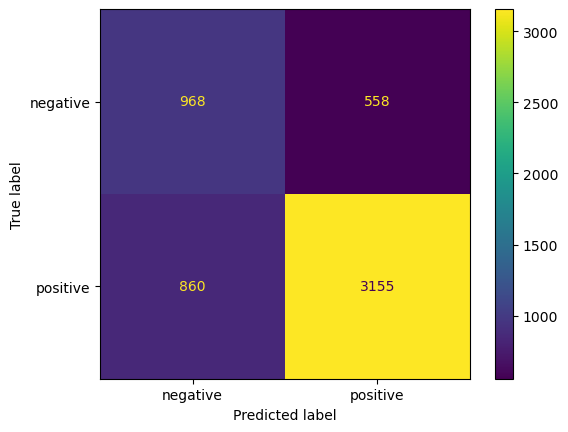

In [27]:
# confusion matrix

get_cm(gs2)

### Multinomial Naive Bayes with TF-IDF

Multinomial Naive Bayes is able to handle text data, and is able to handle sentiment analysis and text classification.

In [28]:
pipe_nb = ImblearnPipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [29]:
pipe_nb_params = {'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
                  'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                  'nb__alpha': [0.001, 0.005, 0.01, 0.1, 1],
                  }

In [30]:
gs3 = GridSearchCV(pipe_nb,
                   param_grid=pipe_nb_params,
                   cv=5)

In [31]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.001, 0.005, 0.01, 0.1, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

#### Scores and confusion matrix

In [32]:
# training data

get_scores(gs3, X_train, y_train)

Accuracy score: 0.8213
Precision score: 0.8224
Specificity score: 0.9609
F1 score: 0.8863


In [33]:
# testing data

get_scores(gs3, X_test, y_test)

Accuracy score: 0.7858
Precision score: 0.794
Specificity score: 0.9512
F1 score: 0.8655


In [34]:
# best hyperparams

print(gs3.best_estimator_)

Pipeline(steps=[('tvec', TfidfVectorizer(max_features=2000)),
                ('nb', MultinomialNB(alpha=0.1))])


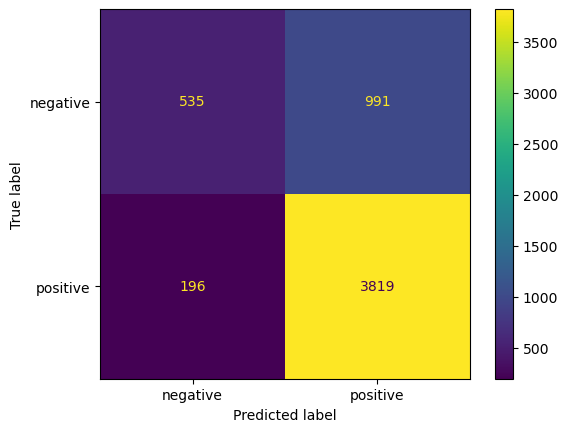

In [35]:
# confusion matrix

get_cm(gs3)

### Multinomial Naive Bayes with TF-IDF and SMOTE

In [36]:
pipe_nb_smt = ImblearnPipeline([
    ('tvec', TfidfVectorizer()),
    ('smote', SMOTE()),
    ('nb', MultinomialNB())
])

In [37]:
gs4 = GridSearchCV(pipe_nb_smt,
                   param_grid=pipe_nb_params,
                   cv=5)

In [38]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('smote', SMOTE()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.001, 0.005, 0.01, 0.1, 1],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

#### Scores and confusion matrix

In [39]:
# training data

get_scores(gs4, X_train, y_train)

Accuracy score: 0.827
Precision score: 0.9199
Specificity score: 0.8339
F1 score: 0.8748


In [40]:
# testing data

get_scores(gs4, X_test, y_test)

Accuracy score: 0.7412
Precision score: 0.8562
Specificity score: 0.7726
F1 score: 0.8123


In [41]:
# best hyperparams

print(gs4.best_estimator_)

Pipeline(steps=[('tvec', TfidfVectorizer(max_features=5000)),
                ('smote', SMOTE()), ('nb', MultinomialNB(alpha=1))])


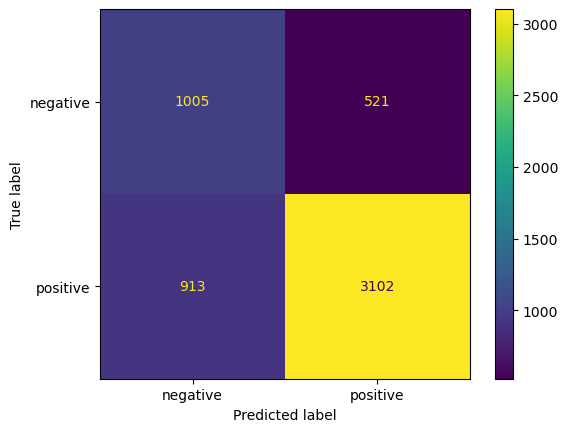

In [42]:
# confusion matrix

get_cm(gs4)

### Random Forest with TF-IDF

Random Forest is able to handle imablanced classification, which this dataset has. It is also able to handle high-dimesional data, which tends to be the case with text analysis. 

In [43]:
pipe_rf = ImblearnPipeline([('tvec', TfidfVectorizer()),
                    ('rf', RandomForestClassifier())])

In [44]:
# setting pipe parameters

pipe_rf_params={'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                'rf__n_estimators': [100, 150, 200],
                'rf__max_depth': [3, 5, 10, 20]}

In [45]:
# instantiate gridsearch

gs5=GridSearchCV(pipe_rf,
                 param_grid=pipe_rf_params,
                 scoring = 'f1',
                 cv=5)

In [46]:
gs5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [3, 5, 10, 20],
                         'rf__n_estimators': [100, 150, 200],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1')

#### Scores and confusion matrix

In [47]:
# training scores

get_scores(gs5, X_train, y_train)

Accuracy score: 0.7639
Precision score: 0.7545
Specificity score: 0.9993
F1 score: 0.8598


In [48]:
# testing scores

get_scores(gs5, X_test, y_test)

Accuracy score: 0.7452
Precision score: 0.743
Specificity score: 0.9913
F1 score: 0.8493


In [49]:
# best hyperparams

print(gs5.best_estimator_)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(max_depth=20))])


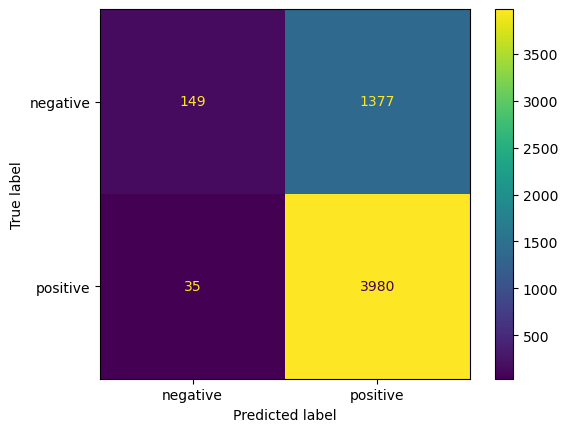

In [50]:
# confusion matrix

get_cm(gs5)

### Random Forest with TF-IDF and SMOTE

In [51]:
pipe_rf_smt = ImblearnPipeline([
    ('tvec', TfidfVectorizer()),
    ('smote', SMOTE()),
    ('rf', RandomForestClassifier())])

In [52]:
# instantiate gridsearch

gs6=GridSearchCV(pipe_rf_smt,
                 param_grid=pipe_rf_params,
                 scoring = 'f1',
                 cv=5)

In [53]:
gs6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('smote', SMOTE()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [3, 5, 10, 20],
                         'rf__n_estimators': [100, 150, 200],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='f1')

#### Scores and confusion matrix

In [54]:
# training scores

get_scores(gs6, X_train, y_train)

Accuracy score: 0.8141
Precision score: 0.8368
Specificity score: 0.9234
F1 score: 0.878


In [55]:
# testing scores

get_scores(gs6, X_test, y_test)

Accuracy score: 0.7656
Precision score: 0.8075
Specificity score: 0.8882
F1 score: 0.8459


In [56]:
# best hyperparams

print(gs6.best_estimator_)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_features=4000, ngram_range=(1, 3))),
                ('smote', SMOTE()),
                ('rf', RandomForestClassifier(max_depth=20, n_estimators=200))])


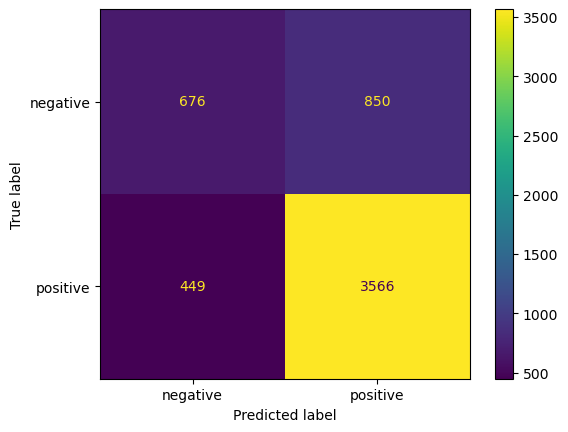

In [57]:
# confusion matrix

get_cm(gs6)

### Model comparison

|Model|SMOTE|Train (F1)| Test (F1)|Remarks|
|-|-|-|-|-|
|Logistic Regression|No|0.8916|0.8356|Overfit|
|Logistic Regression|Yes|0.8899|0.8165|Overfit|
|Multinomial Naive Bayes|No|0.8863|0.8655|Overfit|
|Multinomial Naive Bayes|Yes|0.8748|0.8123|Overfit|
|**Random Forest**|**No**|**0.8598**|**0.8493**|**Good fit**|
|Random Forest|Yes|0.8780|0.8459|Overfit|

### Conclusion

The Random Forest (without SMOTE) model gave the best F1 scores. It is not over nor underfitted, and the F1 scores is higher than the 80% threshold. Hence, the Random Forest (without SMOTE) model would be the best one (out of the six) to be put into production to analyse public sentiment about Singapore.

In order to improve the model, we could collect more data on the minority class in order to correct the imbalance of our data set. We might also want to use social media like Twitter/X, where opinions and public sentiment are more direct. The comments extracted from Youtube videos also included comments about the video creator, which could have skewed the analysis.